In [1]:
% cd /content/drive/MyDrive/MIPT/cv_data

/content/drive/MyDrive/MIPT/cv_data


In [2]:
import os
import cv2
import numpy as np
from time import time
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
plt.style.use('seaborn')

## Data

In [3]:
files = os.listdir('.')
images = [cv2.imread(f) for f in files]

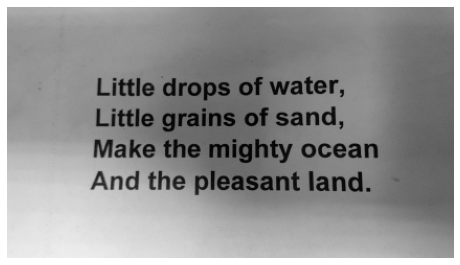

In [4]:
plt.imshow(images[0])
plt.axis('off')
plt.show()

## Useful functions

In [5]:
def get_matches(des_1, des_2):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(np.array(des_1, dtype=np.float32), np.array(des_2, dtype=np.float32), k=2)

    # Filter matches using the Lowe's ratio test
    good_matches = []
    good_init_idx = []
    for i in range(len(matches)):
        m, n = matches[i]
        if m.distance < 0.75 * n.distance:
            good_matches.append([m])
            good_init_idx.append(m.queryIdx)
    return good_init_idx, good_matches

In [6]:
def draw_matches(img_1, img_2, method_name='sift'):
    d = get_descriptor(method_name)
    kp_1, des_1 = d.detectAndCompute(img_1, None)
    kp_2, des_2 = d.detectAndCompute(img_2, None)
    _, good_matches = get_matches(des_1, des_2)

    draw_params = dict(
        matchColor = (0,255,0),
        singlePointColor = (255,0,0),
        flags = cv2.DrawMatchesFlags_DEFAULT
    )

    img_matches = cv2.drawMatchesKnn(img_1, kp_1, img_2, kp_2, good_matches, None, **draw_params)
    plt.imshow(img_matches)
    plt.axis('off')
    plt.show()

In [7]:
def get_descriptor(method_name='sift'):
    if method_name == 'sift':
        d = cv2.xfeatures2d.SIFT_create()
    elif method_name == 'surf':
        d = cv2.xfeatures2d.SURF_create(1000)
    elif method_name == 'orb':
        d = cv2.ORB_create()
    return d

In [8]:
def get_statistics(images, method_name='sift'):
    d = get_descriptor(method_name)
    kp_0, des_0 = d.detectAndCompute(images[0], None)
    all_idx, mean = [], []
    for i in range(1, len(images)):
        kp_i, des_i = d.detectAndCompute(images[i], None)
        good_init_idx, _ = get_matches(des_0, des_i)
        mean.append(len(good_init_idx) / len(kp_0))
        all_idx += good_init_idx

    counter = defaultdict(int, Counter(all_idx))
    counter_dict = {k: counter[k] for k in range(len(kp_0))}
    
    return Counter(list(counter_dict.values())), mean

In [9]:
def visualize_mean(mean):
    plt.title('Repeatability mean between first image and i-th image', fontsize=16)
    plt.xlabel('Image number', fontsize=12)
    plt.ylabel('Mean', fontsize=12)
    plt.plot(np.arange(1, len(mean)+1), mean)
    plt.show()

In [10]:
def visualize_repeatability(counter):
    labels, values = zip(*counter.items())
    plt.figure(figsize=(10,4))
    plt.title('Statistics overall images of points repeatability', fontsize=16)
    plt.xlabel('Number of repetitions', fontsize=12)
    plt.ylabel('Number of points', fontsize=12)
    plt.bar(labels, values)
    plt.show()

## SIFT

In [11]:
start_time = time()
d = get_descriptor('sift')
kp_1, des_1 = d.detectAndCompute(images[0], None)
end_time = time()
print('SIFT point time:', str(round(1e3 * (end_time - start_time) / len(kp_1), 3)) + 'ms')

SIFT point time: 0.182ms


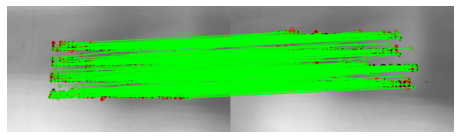

In [12]:
draw_matches(images[0], images[1])

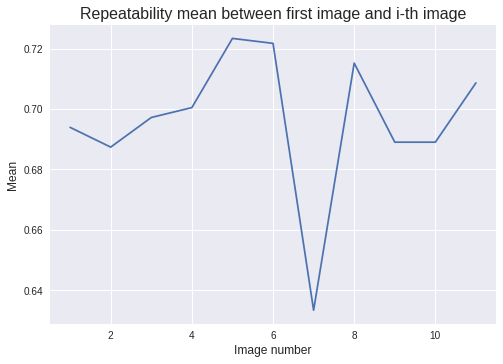

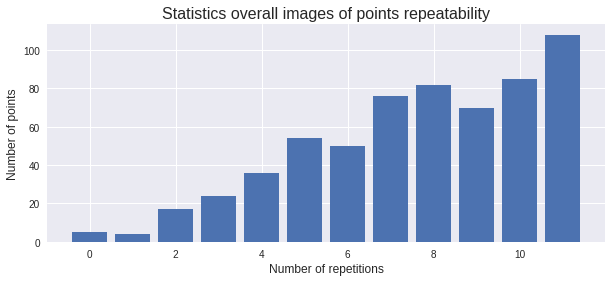

In [13]:
counter_dict, mean = get_statistics(images)
visualize_mean(mean)
print()
visualize_repeatability(counter_dict)

## SURF

In [14]:
start_time = time()
d = get_descriptor('surf')
kp_1, des_1 = d.detectAndCompute(images[0], None)
end_time = time()
print('SURF point time', str(round(1e3 * (end_time - start_time) / len(kp_1), 3)) + 'ms')

SURF point time 0.487ms


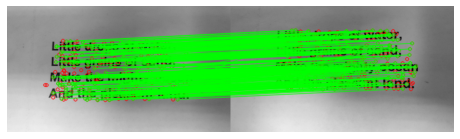

In [15]:
draw_matches(images[0], images[1], 'surf')

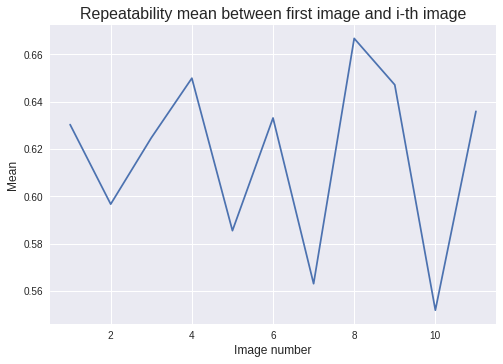

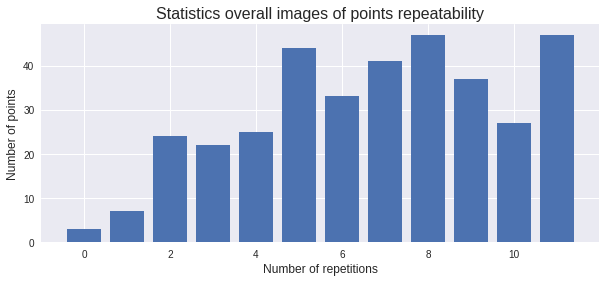

In [16]:
counter_dict, mean = get_statistics(images, 'surf')
visualize_mean(mean)
print()
visualize_repeatability(counter_dict)

## ORB

In [17]:
start_time = time()
d = get_descriptor('orb')
kp_1, des_1 = d.detectAndCompute(images[0], None)
end_time = time()
print('ORB point time:', str(round(1e3 * (end_time - start_time) / len(kp_1), 3)) + 'ms')

ORB point time: 0.022ms


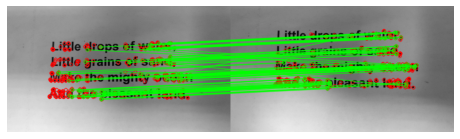

In [18]:
draw_matches(images[0], images[1], 'orb')

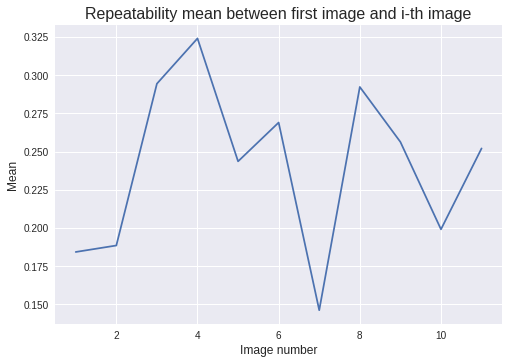

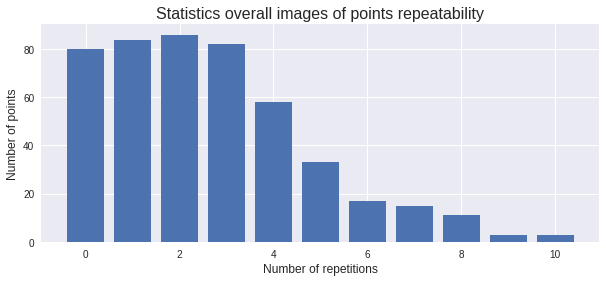

In [19]:
counter_dict, mean = get_statistics(images, 'orb')
visualize_mean(mean)
print()
visualize_repeatability(counter_dict)

## Выводы

По скорости у меня получились ORB на первом месте, SIFT на втором, а SURF на последнем. Однако должно быть не так, учитывая ускорение SURF'a за счет вычисления гессиана с помощью интегральных изображний, этот метод должен быть быстрее SIFT'а. Возможно, такие значения были получены из-за особенностей реализации OpenCV.